# Convolutional Neural Network for Eye Diseases Classification

In this Jupyter Notebook, we explore 5 different convolutional neural network (CNN) models without transfer learning.  

The objective is to understand how varying network parameters such as the number of convolutional and fully connected layers, activation functions, and optimizers, affect model performance.  

Through experiments, we analyze the impact of architectural choices on accuracy, training dynamics, and generalization.

## Imports

In [1]:
import torch
import os
import torchvision
import opendatasets as od
import wandb
import random
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# Device selection to use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Loading and Exploration

We download the eye diseases classification dataset and prepare the data for training, validation, and testing. Transformations include resizing images to 256x256 and normalization with ImageNet statistics.  

Splitting is done with 80% for training, 10% for validation, and 10% for testing. Custom subsets wrap the dataset to apply different transformations for train and test/validation sets.

In [3]:
od.download("https://www.kaggle.com/datasets/gunavenkatdoddi/eye-diseases-classification")


Skipping, found downloaded files in ".\eye-diseases-classification" (use force=True to force download)


In [4]:
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #Using ImageNet statistics
    ])

transform_test_val = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

In [5]:
full_dataset = torchvision.datasets.ImageFolder(root='eye-diseases-classification/dataset')

### Custom Subset with Transforms

The default `Subset` does not apply transformations, so we wrap it in a custom class that applies transforms in the moment.

In [6]:
class TransformedSubset:
    def __init__(self, subset: Subset, transform: transforms.Compose):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index: int) -> tuple:
        img, label = self.subset[index]
        img = self.transform(img)
        return img, label
    
    def __len__(self) -> int:
        return len(self.subset)

### Dataset Splitting

We shuffle the indices using a fixed seed for reproducibility and split the dataset into training, validation, and test sets with proportions of 80%, 10%, and 10%, respectively.

In [7]:
np.random.seed(42)
index = np.arange(len(full_dataset))
np.random.shuffle(index)

train_percent = 0.8
test_val_percent = 0.1

train_index = int(train_percent * len(full_dataset))
test_val_index = int((train_percent + test_val_percent) * len(full_dataset))

dataset_train = TransformedSubset(Subset(full_dataset, index[:train_index]), transform_train)
dataset_val = TransformedSubset(Subset(full_dataset, index[train_index:test_val_index]), transform_test_val)
dataset_test = TransformedSubset(Subset(full_dataset, index[test_val_index:]), transform_test_val)

### DataLoader Creation

Finally, we create de DataLoaders for train, validation and test to generate batches during training and evaluation.

In [8]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

## Visualizate Images of Dataset

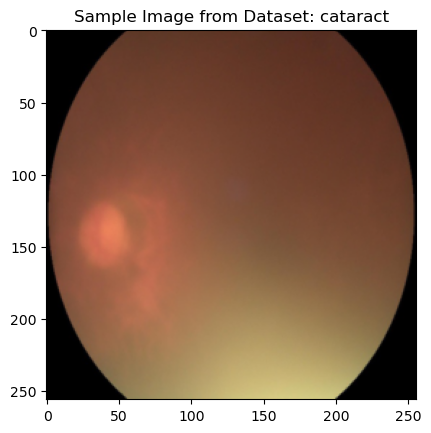

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
idx = random.randint(0, images.shape[0] - 1)
image = images[idx].numpy()
image = np.transpose(image, (1, 2, 0)) # For matplotlib we need to change the shape

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
image = std * image + mean 
image = np.clip(image, 0, 1)

plt.title("Sample Image from Dataset: {class_name}".format(class_name=full_dataset.classes[labels[idx].item()]))
plt.imshow(image)
plt.show()

## CNN Models


Below we present five convolutional neural network models for eye disease classification.  

All models use the same training and evaluation pipeline illustrated below. 

This pipeline includes training with early stopping, validation, testing, logging with W&B, and plotting loss and accuracy curves.

In [10]:
results = [] # This is a list to store metrics for every model for final comparison plots

In [11]:
def train_validate(model, train_loader, val_loader, device, criterion, optimizer, epochs, early_stopping_criteria, scheduler=None, save_path="models/model_default"):
    
    torch.cuda.empty_cache()
    
    os.makedirs(save_path, exist_ok=True)
    best_model_file = os.path.join(save_path, "best_model.pth")
    
    best_val_loss = float('inf')
    best_val_accuracy = 0.0
    early_stopping_counter = 0
    
    total_train_loss = []
    total_val_loss = []
    total_train_accuracy = []
    total_val_accuracy = []

    for epoch in range(epochs):

        # TRAIN
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
            

        train_loss = running_loss / len(train_loader)
        total_train_loss.append(train_loss)
        train_accuracy = 100 * train_correct / train_total
        total_train_accuracy.append(train_accuracy)

        # VALIDATION
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        total_val_loss.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        total_val_accuracy.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), best_model_file)

        if early_stopping_counter >= early_stopping_criteria:
            print(f"Early stopping at epoch {epoch+1}")
            break

        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

        current_lr = optimizer.param_groups[0]["lr"]


        # Log in WanDB
        wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss": val_loss,
        "val_accuracy": val_accuracy,
        "learning_rate": current_lr
        })


    return total_train_loss, total_val_loss, total_train_accuracy, total_val_accuracy, best_model_file 

In [12]:
def test(model, test_loader, device, path_best_model):
    model.load_state_dict(torch.load(path_best_model))
    model.eval()

    test_correct = 0
    test_total = 0
    y_pred = []
    y_true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    test_accuracy = 100 * test_correct / test_total
    print(f"Accuracy of the model on test images: {test_accuracy:.2f}%")

    wandb.log({"test_accuracy": test_accuracy})
    wandb.finish()

    return y_true, y_pred, test_accuracy

In [13]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, save_path=None):
    
    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(xticks_rotation=45)
    plt.title("Confusion Matrix")
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "confusion_matrix.png"))
    plt.show()

In [14]:
def plot_metrics(total_train_loss, total_val_loss, total_train_accuracy, total_val_accuracy, save_path=None):

    if save_path is not None:
        os.makedirs(save_path, exist_ok=True)

    # LOSS
    plt.figure()
    plt.plot(range(1, len(total_train_loss) + 1), total_train_loss, label='Training Loss')
    plt.plot(range(1, len(total_val_loss) + 1), total_val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.xlim(1, len(total_train_loss))
    plt.xticks(range(1, len(total_train_loss) + 1, max(1, len(total_train_loss) // 10)))
    plt.title('Training and Validation Loss')
    plt.grid()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "loss_graphic.png"), bbox_inches='tight')
    plt.show()

    # ACCURACY
    plt.figure()
    plt.plot(range(1, len(total_train_accuracy) + 1), total_train_accuracy, label='Training Accuracy')
    plt.plot(range(1, len(total_val_accuracy) + 1), total_val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.xlim(1, len(total_val_accuracy))
    plt.xticks(range(1, len(total_val_accuracy) + 1, max(1, len(total_val_accuracy) // 10)))
    plt.ylim(0, 100)
    plt.title('Training and Validation Accuracy')
    plt.grid()
    if save_path is not None:
        plt.savefig(os.path.join(save_path, "accuracy_graphic.png"), bbox_inches='tight')
    plt.show()

### Model 1 – Deep CNN with Four Convolutional Blocks


This first architecture stacks four convolutional blocks with 3 × 3 kernels, batch normalisation, ReLU activation and max pooling, progressively increasing the number of channels from 3 to 256 to capture as many relevant features as possible.

After flattening, two fully connected layers with ReLU and dropout (0.5) act as the classification head, and a final linear layer produces the predictions for the four eye disease classes.

In [15]:
class ConvNetModel1(nn.Module):
    def __init__(self):
        super(ConvNetModel1, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(256 * 16 * 16, 512)
        self.dropout1 = nn.Dropout(p=0.5)
        
        self.fc2 = nn.Linear(512, 256)
        self.dropout2 = nn.Dropout(p=0.5)
        
        self.fc3 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        
        return x

#### Training and Evaluation of Model 1

##### Experiment setup

We train Model 1 using Adam with a learning rate of 0.001, mini-batches of size 32 and a maximum of 200 epochs, with early stopping = 20, no learning rate scheduler.

In [16]:
wandb.init(
    project="eye-disease-classification",
    name="model1_custom_cnn_4conv",
    config={
        "learning_rate": 0.001,
        "epochs": 200,
        "batch_size": 32,
        "architecture": "custom_cnn_4conv"
    }
)

run_dir = "models/model1"

wandb: Currently logged in as: pabcablan2005 (pabcablan2005-universidad-de-las-palmas-de-gran-canaria) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [17]:
model = ConvNetModel1().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

c:\Users\pabca\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1357: UserWarning: expandable_segments not supported on this platform (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\c10/cuda/CUDAAllocatorConfig.h:35.)
  return t.to(


In [ ]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    epochs=200, early_stopping_criteria=20, save_path=run_dir
)

Epoch 1/5, Train Loss: 2.6695, Train Acc: 32.85%, Val Loss: 1.1952, Val Acc: 48.82%
Epoch 2/5, Train Loss: 1.2065, Train Acc: 44.06%, Val Loss: 1.0557, Val Acc: 55.92%
Epoch 3/5, Train Loss: 1.1195, Train Acc: 47.61%, Val Loss: 1.0157, Val Acc: 56.87%
Epoch 4/5, Train Loss: 1.0855, Train Acc: 49.99%, Val Loss: 0.9720, Val Acc: 59.72%
Epoch 5/5, Train Loss: 1.0250, Train Acc: 53.19%, Val Loss: 0.9168, Val Acc: 60.19%


In [19]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 58.29%


epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
train_accuracy,▁▅▆▇█
train_loss,█▂▁▁▁
val_accuracy,▁▅▆██
val_loss,█▄▃▂▁
epoch,5
learning_rate,0.001
test_accuracy,58.29384
train_accuracy,53.18707


In [20]:
results.append({
    "name" : "Model 1",
    "val_loss": total_val_loss,
    "val_acc": total_val_acc,
    "train_loss": total_train_loss,
    "train_acc": total_train_acc,
    "test_acc": test_acc
})

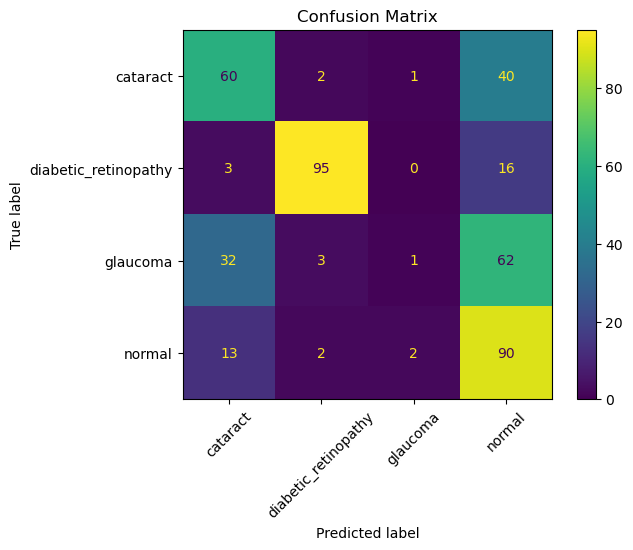

In [21]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

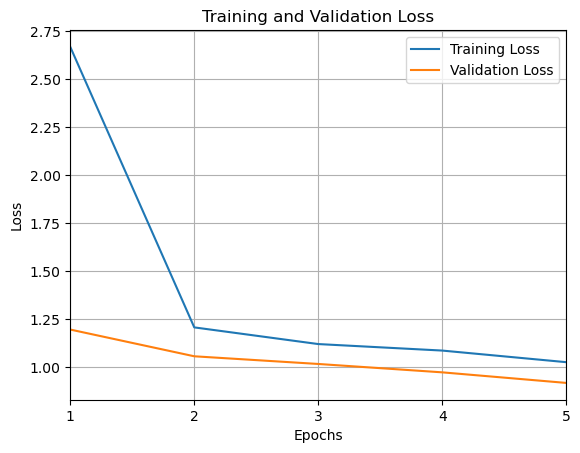

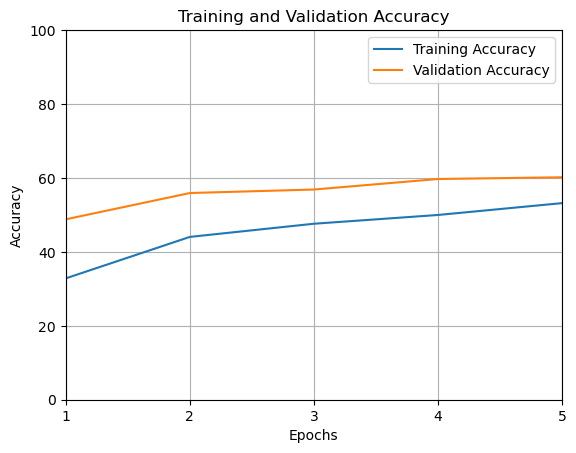

In [22]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)

### Model 2 – Shallow CNN with Fewer Parameters


This second architecture uses three convolutional blocks with 3 × 3 kernels, batch normalisation, ReLU activation and max pooling, increasing the number of channels from 3 to 128 while keeping the overall depth and parameter count significantly lower than in Model 1.

After the convolutional part, the network flattens the features and passes them through a single fully connected layer of size 256 followed by a final linear layer that produces the predictions for the four eye disease classes, resulting in a lighter model.

In [23]:
class ConvNetModel2(nn.Module):
    def __init__(self):
        super(ConvNetModel2, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(128 * 32 * 32, 256)
    
        self.fc2 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        
        return x

#### Training and Evaluation of Model 2

##### Experiment setup

We train Model 2 using Adam with a learning rate of 0.001, mini-batches of size 32 and a maximum of 200 epochs, with early stopping = 25, no learning rate scheduler.

In [24]:
wandb.init(
    project="eye-disease-classification",
    name="model2_custom_cnn_3conv",
    config={
        "learning_rate": 0.001,
        "epochs": 200,
        "batch_size": 32,
        "architecture": "custom_cnn_3conv"
    }
)

run_dir = "models/model2"

In [25]:
model = ConvNetModel2().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    epochs=200, early_stopping_criteria=25, save_path=run_dir
)

Epoch 1/5, Train Loss: 5.6113, Train Acc: 51.85%, Val Loss: 0.9604, Val Acc: 63.27%
Epoch 2/5, Train Loss: 0.8395, Train Acc: 66.11%, Val Loss: 0.7328, Val Acc: 72.99%
Epoch 3/5, Train Loss: 0.6902, Train Acc: 71.12%, Val Loss: 0.7026, Val Acc: 70.62%
Epoch 4/5, Train Loss: 0.6083, Train Acc: 73.47%, Val Loss: 0.5457, Val Acc: 77.96%
Epoch 5/5, Train Loss: 0.5900, Train Acc: 74.80%, Val Loss: 0.6179, Val Acc: 72.75%


In [27]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 80.57%


epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
train_accuracy,▁▅▇██
train_loss,█▁▁▁▁
val_accuracy,▁▆▅█▆
val_loss,█▄▄▁▂
epoch,5
learning_rate,0.001
test_accuracy,80.56872
train_accuracy,74.79988


In [28]:
results.append({
    "name" : "Model 2",
    "val_loss": total_val_loss,
    "val_acc": total_val_acc,
    "train_loss": total_train_loss,
    "train_acc": total_train_acc,
    "test_acc": test_acc
})

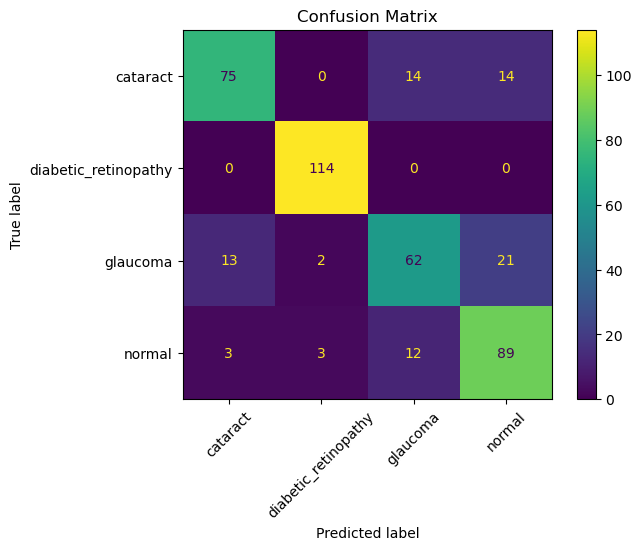

In [29]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

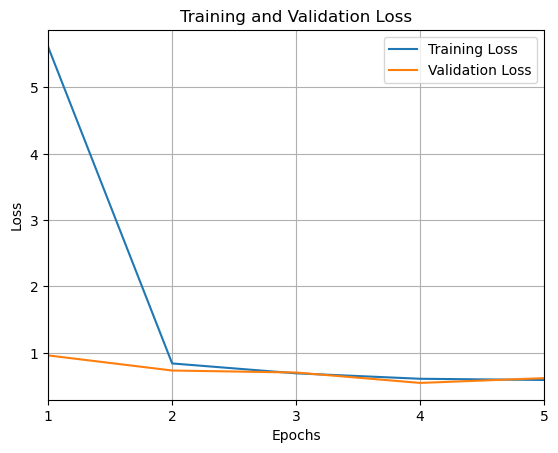

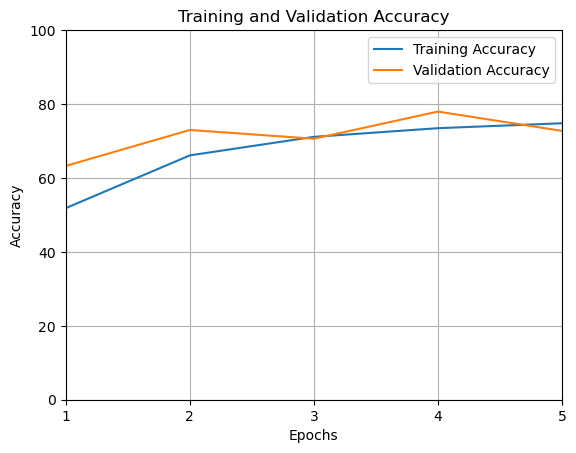

In [30]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)

### Model 3 – Deeper CNN with Strong Regularisation


This third architecture increases depth by stacking five convolutional blocks with 3 × 3 kernels and batch normalisation, growing the number of channels from 3 to 128 while applying max pooling only after the 2nd, 4th and 5th blocks to control the spatial resolution. Two-dimensional dropout with rate 0.3 is used in the last two convolutional blocks to reduce overfitting.

After flattening the feature maps at 128 × 32 × 32, the network uses two fully connected layers of sizes 512 and 256 with ReLU activation and dropout (0.5) in the first, followed by a final linear layer that outputs the predictions for the four eye disease classes, combining higher representational capacity with strong regularisation.

In [31]:
class ConvNetModel3(nn.Module):
    def __init__(self):
        super(ConvNetModel3, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop4 = nn.Dropout2d(p=0.3)

        self.conv5 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.drop5 = nn.Dropout2d(p=0.3)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.dropout_fc = nn.Dropout(p=0.5)

        self.fc2 = nn.Linear(512, 256)

        self.fc3 = nn.Linear(256, 4)

    def forward(self, x):
       
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)
        x = self.drop4(x)
        
        x = self.conv5(x)
        x = self.bn5(x)
        x = F.relu(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)

        x = self.fc2(x)
        x = F.relu(x)

        x = self.fc3(x)

        return x


#### Training and Evaluation of Model 3

##### Experiment setup

We train Model 3 using AdamW with a learning rate of 0.001, weight decay of 1e-2 and mini-batches of size 32, for a maximum of 120 epochs with early stopping set to 20. A ReduceLROnPlateau scheduler is applied on the validation loss (factor 0.5, patience 5) to automatically decrease the learning rate when the model stops improving.

In [32]:
wandb.init(
    project="eye-disease-classification",
    name="model3_custom_cnn_5conv_reg",
    config={
        "learning_rate": 0.001,
        "epochs": 120,
        "batch_size": 32,
        "architecture": "custom_cnn_5conv_reg"
    }
)

run_dir = "models/model3"

In [33]:
model = ConvNetModel3().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

In [ ]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    scheduler=scheduler, epochs=120, early_stopping_criteria=20, save_path=run_dir
)

Epoch 1/5, Train Loss: 2.5903, Train Acc: 43.02%, Val Loss: 0.8924, Val Acc: 59.95%
Epoch 2/5, Train Loss: 0.9581, Train Acc: 55.47%, Val Loss: 0.7907, Val Acc: 60.90%
Epoch 3/5, Train Loss: 0.8592, Train Acc: 58.82%, Val Loss: 0.7397, Val Acc: 61.61%
Epoch 4/5, Train Loss: 0.8245, Train Acc: 59.15%, Val Loss: 0.7419, Val Acc: 62.09%
Epoch 5/5, Train Loss: 0.8164, Train Acc: 61.55%, Val Loss: 0.7449, Val Acc: 66.11%


In [35]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 66.59%


epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
train_accuracy,▁▆▇▇█
train_loss,█▂▁▁▁
val_accuracy,▁▂▃▃█
val_loss,█▃▁▁▁
epoch,5
learning_rate,0.001
test_accuracy,66.58768
train_accuracy,61.54758


In [36]:
results.append({
    "name" : "Model 3",
    "val_loss": total_val_loss,
    "val_acc": total_val_acc,
    "train_loss": total_train_loss,
    "train_acc": total_train_acc,
    "test_acc": test_acc
})

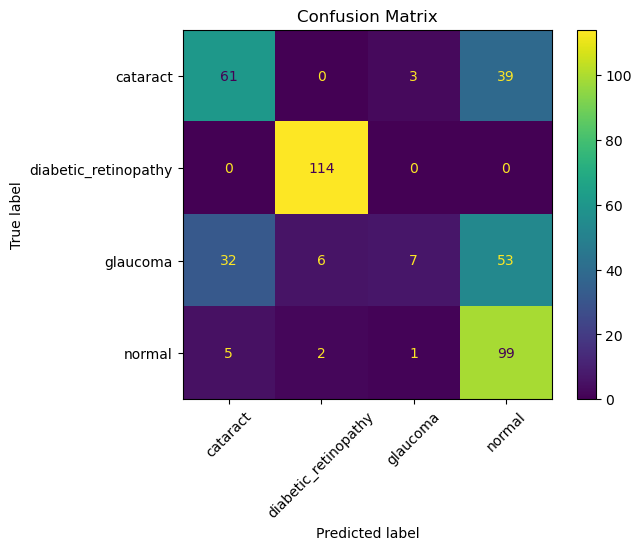

In [37]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

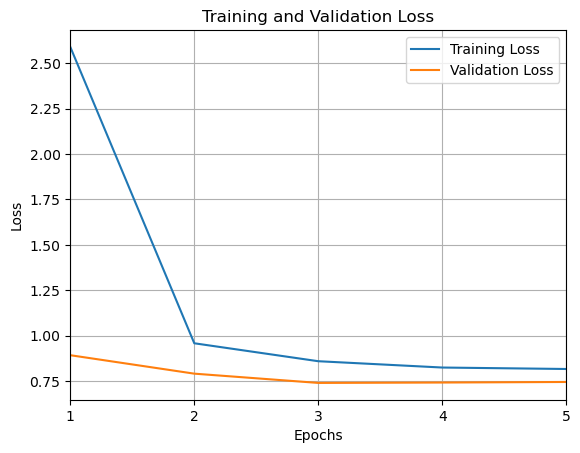

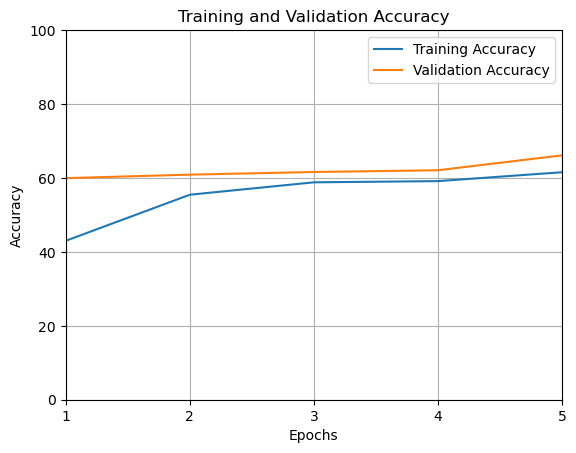

In [38]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)

### Model 4 – Narrow CNN with LeakyReLU and SGD


This fourth architecture is a narrower CNN that uses four convolutional blocks with 3 × 3 kernels, batch normalisation, LeakyReLU activation (negative slope 0.01) and max pooling, increasing the number of channels from 3 to 128 while keeping the overall width of the network relatively small.

After the convolutional feature extraction, the network flattens the activations at 128 × 16 × 16 and passes them through a single fully connected layer of size 256 followed by a final linear layer that outputs the predictions for the four eye disease classes, providing a lighter architecture trained with a more “classical” optimisation setup.

In [39]:
class ConvNetModel4(nn.Module):
    def __init__(self):
        super(ConvNetModel4, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, 4)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.leaky_relu(x, negative_slope=0.01)
        x = self.pool4(x)

        x = self.flatten(x)

        x = self.fc1(x)
        x = F.leaky_relu(x, negative_slope=0.01)

        x = self.fc2(x)
        
        return x


#### Training and Evaluation of Model 4

##### Experiment setup

We train Model 4 using SGD with a learning rate of 0.01, momentum 0.9, mini-batches of size 32 and a maximum of 200 epochs, with early stopping set to 20. A StepLR scheduler with step size 20 and gamma 0.1 is applied to decay the learning rate during training, allowing us to compare this more “classical” setup.

In [40]:
wandb.init(
    project="eye-disease-classification",
    name="model4_custom_cnn_4conv_leaky",
    config={
        "learning_rate": 0.01,
        "epochs": 200,
        "batch_size": 32,
        "architecture": "custom_cnn_4conv_leaky"
    }
)

run_dir = "models/model4"

In [41]:
model = ConvNetModel4().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [ ]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    epochs=200, early_stopping_criteria=20, save_path=run_dir
)

Epoch 1/5, Train Loss: 1.1097, Train Acc: 49.13%, Val Loss: 0.8758, Val Acc: 64.45%
Epoch 2/5, Train Loss: 0.8674, Train Acc: 59.86%, Val Loss: 0.7965, Val Acc: 62.80%
Epoch 3/5, Train Loss: 0.8204, Train Acc: 61.87%, Val Loss: 0.7575, Val Acc: 66.11%
Epoch 4/5, Train Loss: 0.7674, Train Acc: 63.77%, Val Loss: 0.7423, Val Acc: 66.59%
Epoch 5/5, Train Loss: 0.7102, Train Acc: 67.57%, Val Loss: 0.7022, Val Acc: 66.35%


In [43]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 65.40%


epoch,▁▃▅▆█
learning_rate,▁▁▁▁▁
test_accuracy,▁
train_accuracy,▁▅▆▇█
train_loss,█▄▃▂▁
val_accuracy,▄▁▇██
val_loss,█▅▃▃▁
epoch,5
learning_rate,0.01
test_accuracy,65.40284
train_accuracy,67.56597


In [44]:
results.append({
    "name" : "Model 4",
    "val_loss": total_val_loss,
    "val_acc": total_val_acc,
    "train_loss": total_train_loss,
    "train_acc": total_train_acc,
    "test_acc": test_acc
})

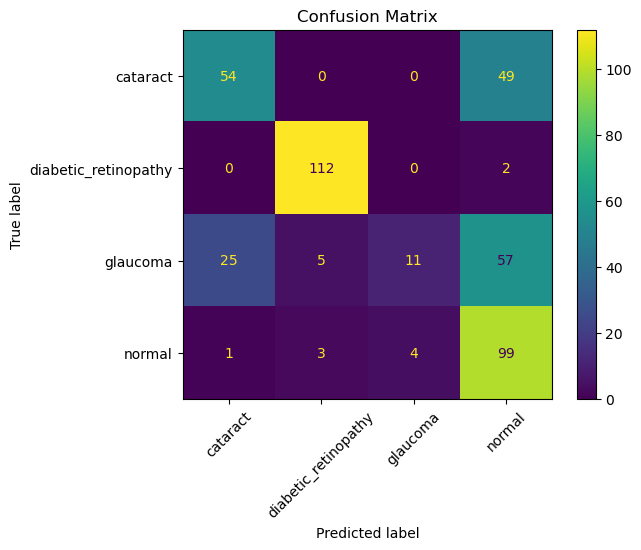

In [45]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

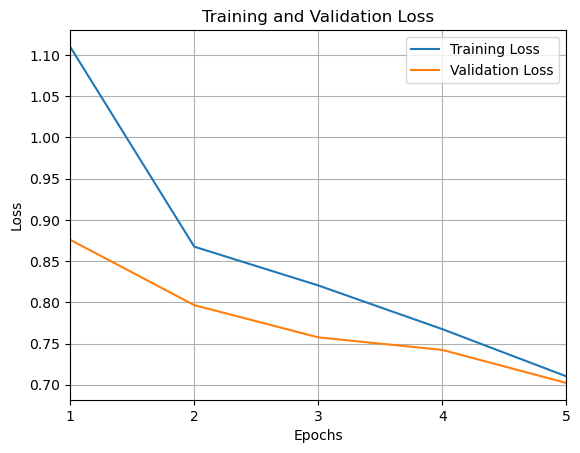

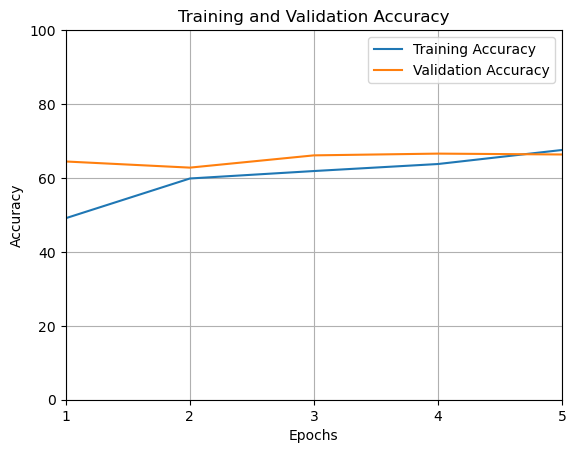

In [46]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)

### Model 5 – CNN with Global Average Pooling Head

This fifth architecture shares the same convolutional backbone as Model 1, with four convolutional blocks using 3 × 3 kernels, batch normalisation, ReLU activation and 2 × 2 max pooling, increasing the number of channels from 3 to 256. 

After the last convolutional block, an adaptive global average pooling layer compresses each 16 × 16 feature map into a single value per channel that is flattened, regularised with dropout (0.3) and fed directly into a final linear layer that outputs the predictions for the four eye disease classes.

In [47]:
class ConvNetModel5(nn.Module):
    def __init__(self):
        super(ConvNetModel5, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.pool5 = nn.AdaptiveAvgPool2d((1,1))

        self.flatten = nn.Flatten()

        self.dropout1 = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(256, 4)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = self.pool5(x)

        x = self.flatten(x)
        
        x = self.dropout1(x)
        x = self.fc1(x)
        
        return x

#### Training and Evaluation of Model 5

##### Experiment setup

We train Model 5 using Adam with a learning rate of 0.0005, mini-batches of size 32 and a maximum of 200 epochs, with early stopping set to 20. A CosineAnnealingLR scheduler is used with `T_max = 200` (equal to the maximum number of epochs for this model), so that the learning rate is smoothly annealed following a cosine schedule during training.

In [48]:
wandb.init(
    project="eye-disease-classification",
    name="model5_custom_cnn_4conv_avg_pool",
    config={
        "learning_rate": 0.0005,
        "epochs": 200,
        "batch_size": 32,
        "architecture": "custom_cnn_4conv_gap"
    }
)

run_dir = "models/model5"

In [49]:
model = ConvNetModel5().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [ ]:
total_train_loss, total_val_loss, total_train_acc, total_val_acc, best_model_file = train_validate(
    model, train_loader, val_loader, 
    device, criterion, optimizer, 
    scheduler=scheduler, epochs=200, early_stopping_criteria=20, save_path=run_dir
)

Epoch 1/5, Train Loss: 1.1141, Train Acc: 49.33%, Val Loss: 1.0835, Val Acc: 54.50%
Epoch 2/5, Train Loss: 0.9355, Train Acc: 61.37%, Val Loss: 0.9688, Val Acc: 55.92%
Epoch 3/5, Train Loss: 0.7694, Train Acc: 69.46%, Val Loss: 1.0052, Val Acc: 53.08%
Epoch 4/5, Train Loss: 0.6716, Train Acc: 73.88%, Val Loss: 0.7344, Val Acc: 70.38%
Epoch 5/5, Train Loss: 0.6157, Train Acc: 76.73%, Val Loss: 0.7345, Val Acc: 72.75%


In [51]:
y_true, y_pred, test_acc = test(model, test_loader, device, path_best_model=best_model_file)

Accuracy of the model on test images: 68.25%


epoch,▁▃▅▆█
learning_rate,█▇▆▄▁
test_accuracy,▁
train_accuracy,▁▄▆▇█
train_loss,█▅▃▂▁
val_accuracy,▂▂▁▇█
val_loss,█▆▆▁▁
epoch,5
learning_rate,0.0005
test_accuracy,68.24645
train_accuracy,76.72695


In [52]:
results.append({
    "name" : "Model 5",
    "val_loss": total_val_loss,
    "val_acc": total_val_acc,
    "train_loss": total_train_loss,
    "train_acc": total_train_acc,
    "test_acc": test_acc
})

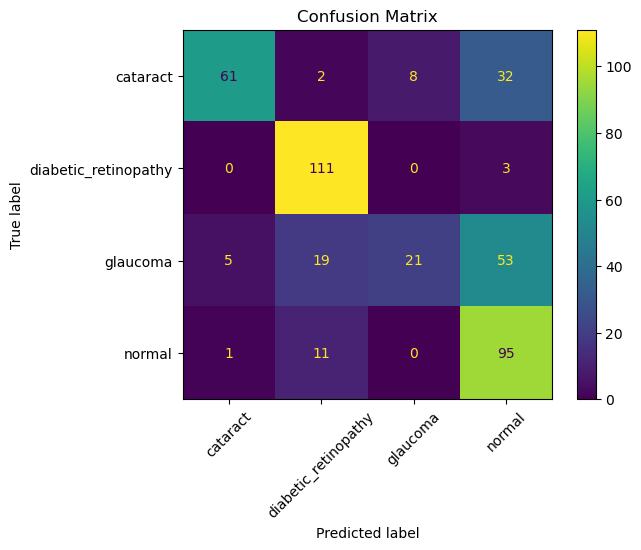

In [53]:
plot_confusion_matrix(y_true, y_pred, class_names=full_dataset.classes, save_path=run_dir)

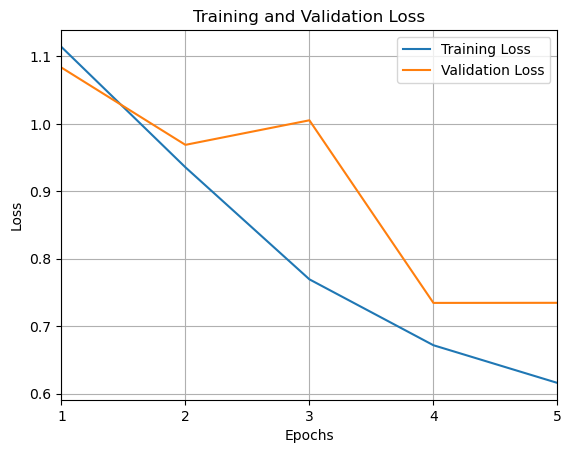

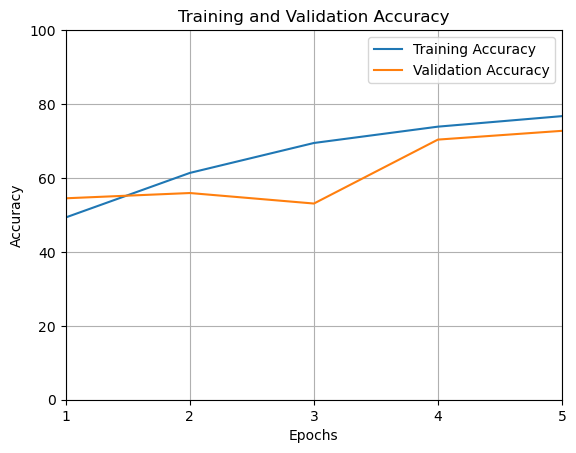

In [54]:
plot_metrics(total_train_loss, total_val_loss, total_train_acc, total_val_acc, save_path=run_dir)

## Final Conclusions

In [55]:
model_names = [r["name"] for r in results]
colors = {
    "Model 1": "tab:blue",
    "Model 2": "tab:orange",
    "Model 3": "tab:green",
    "Model 4": "tab:red",
    "Model 5": "tab:purple"
}

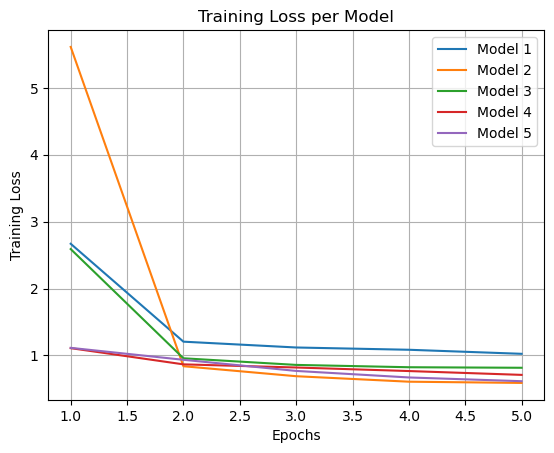

In [56]:
# Training Loss
plt.figure()
for r in results:
    epochs = range(1, len(r["train_loss"]) + 1)
    plt.plot(epochs, r["train_loss"], label=r["name"], color=colors[r["name"]])
plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss per Model")
plt.legend()
plt.grid()
plt.show()

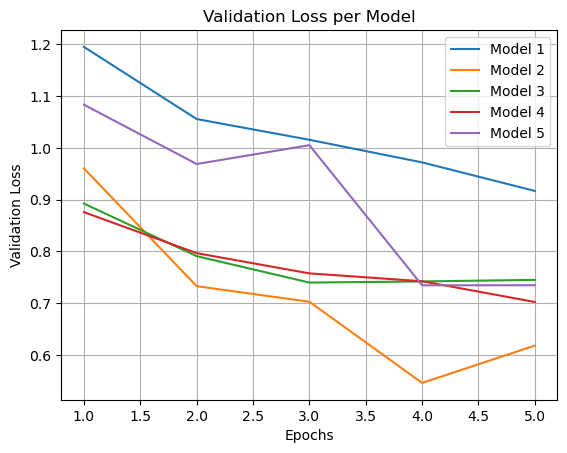

In [57]:
# Validation Loss
plt.figure()
for r in results:
    epochs = range(1, len(r["val_loss"]) + 1)
    plt.plot(epochs, r["val_loss"], label=r["name"], color=colors[r["name"]])
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss per Model")
plt.legend()
plt.grid()
plt.show()

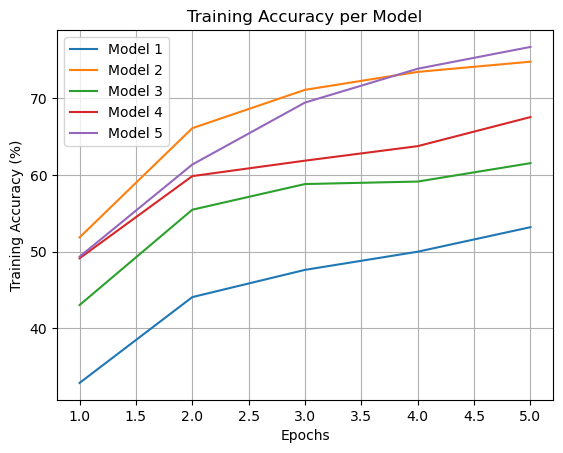

In [58]:
# Training Accuracy
plt.figure()
for r in results:
    epochs = range(1, len(r["train_acc"]) + 1)
    plt.plot(epochs, r["train_acc"], label=r["name"], color=colors[r["name"]])
plt.xlabel("Epochs")
plt.ylabel("Training Accuracy (%)")
plt.title("Training Accuracy per Model")
plt.legend()
plt.grid()
plt.show()

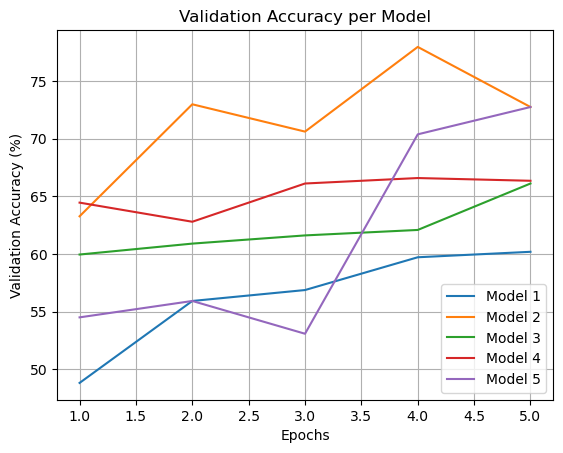

In [59]:
# Validation Accuracy
plt.figure()
for r in results:
    epochs = range(1, len(r["val_acc"]) + 1)
    plt.plot(epochs, r["val_acc"], label=r["name"], color=colors[r["name"]])
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy per Model")
plt.legend()
plt.grid()
plt.show()

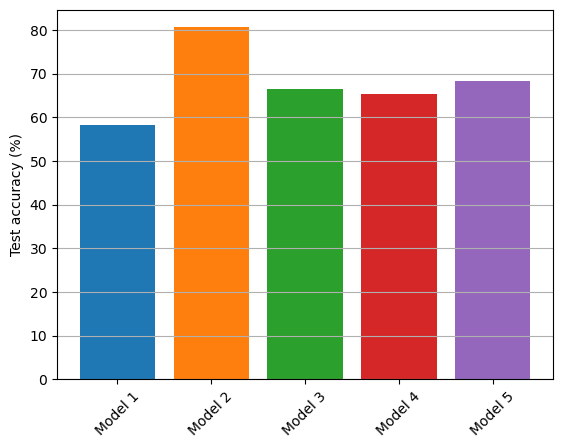

In [60]:
# Test Accuracy
test_acc = [r["test_acc"] for r in results]
bar_colors = [colors[name] for name in model_names]

plt.bar(model_names, test_acc, color=bar_colors)
plt.ylabel("Test accuracy (%)")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.show()

### Adaptive Convolutional Network (Extra)

This adaptive CNN was implemented to experiment with highly configurable architectures. Instead of hard‑coding a specific layout, the network is built dynamically from lists that control the number of convolutional layers, their filters, and the fully connected layers.

In practice, this design didn't worked well, it became unstable for a lot of the architectures. The combination of dynamic layer construction, list‑based configurations and large input images made GPU memory usage harder to control.

In [61]:
class AdaptativeConvNet(nn.Module):
    def __init__(
        self, num_conv_layers, list_conv_filters, num_fc_layers, list_fc_neurons, in_channels=3,
        out_channels=4, activation_function=nn.ReLU, use_batchnorm_conv=True, use_batchnorm_fc=False,
        use_dropout_fc=False, use_dropout_conv=False, dropout_fc_rate=0.5, dropout_conv_rate=0.5, img_shape=(3, 256, 256)):
        
        super(AdaptativeConvNet, self).__init__()

        if num_conv_layers != len(list_conv_filters):
            raise ValueError(f"num_conv_layers = {num_conv_layers} pero list_conv_filters tiene {len(list_conv_filters)} elementos")
        if num_fc_layers != len(list_fc_neurons):
            raise ValueError(f"num_fc_layers = {num_fc_layers} pero list_fc_neurons tiene {len(list_fc_neurons)} elementos")

        conv_layers = []
        input_channels = in_channels
        for nf in list_conv_filters:
            conv_layers.append(nn.Conv2d(input_channels, nf, kernel_size=3, padding=1))
            if use_batchnorm_conv:
                conv_layers.append(nn.BatchNorm2d(nf))
            conv_layers.append(activation_function)
            if use_dropout_conv:
                conv_layers.append(nn.Dropout2d(dropout_conv_rate))
            input_channels = nf
        self.conv = nn.Sequential(*conv_layers)
        self.flatten = nn.Flatten()

        fc_input_dim = self.calc_fc_input_dim(img_shape)

        fc_layers = []
        prev_dim = fc_input_dim
        for fc_dim in list_fc_neurons:
            fc_layers.append(nn.Linear(prev_dim, fc_dim))
            if use_batchnorm_fc:
                fc_layers.append(nn.BatchNorm1d(fc_dim))
            fc_layers.append(activation_function)
            if use_dropout_fc:
                fc_layers.append(nn.Dropout(dropout_fc_rate))
            prev_dim = fc_dim
        fc_layers.append(nn.Linear(prev_dim, out_channels))
        self.fc = nn.Sequential(*fc_layers)

    def calc_fc_input_dim(self, img_shape):
        with torch.no_grad():
            dummy = torch.zeros(1, *img_shape)
            out = self.conv(dummy)
            out = out.flatten(1)
            return out.shape[1]

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x